## Introduction

Financial markets alternate between periods of optimism and expansion (**Risk-On**) and phases of defensiveness and elevated volatility (**Risk-Off**).  
Because these regime shifts are not directly observable, detecting them requires methods that can uncover hidden structure in the data without relying on labeled examples.

In this notebook, we use **unsupervised machine learning** to infer market regimes from cryptocurrency-derived features.  
We compare three complementary perspectives:

1. **Hidden Markov Model (HMM)** — a probabilistic latent-state model that explicitly captures temporal persistence and transition dynamics  
2. **Gaussian Mixture Model (GMM)** — a distribution-based clustering method that groups observations with similar statistical profiles  
3. **Autoencoder + K-Means** — a deep-learning approach that learns nonlinear representations before clustering them in latent space  

Together, these methods allow us to examine whether regimes in crypto markets are better explained by temporal structure, distributional shifts, or nonlinear patterns.

The notebook follows a clear narrative:  
data preparation (Section 2), theoretical motivation of the models (Section 3), model training (Section 4), visual and quantitative comparison of regime assignments (Sections 5–6), and a final discussion of implications, conclusions, and limitations (Sections 7–9).

In [37]:
# Import required libraries
import sys
sys.path.insert(0, '..')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

from src.models.hmm import fit_hmm, decode_hmm, HMMConfig
from src.models.gmm import fit_gmm, predict_gmm, GMMConfig
from src.models.autoencoder import fit_autoencoder, predict_autoencoder, AutoencoderConfig
from src.evaluation.metrics import compute_regime_stats, compute_transition_matrix
from src.evaluation.plots import plot_regime_timeline, plot_conditional_stats

# Set style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (14, 6)

print("✅ Imports successful")

✅ Imports successful


## Data & Features

We construct features from four data sources: **Bitcoin (BTC-USD)**, **Ethereum (ETH-USD)**, **S&P 500 (^GSPC)**, and **VIX (volatility index)**. For each cryptocurrency, we compute log returns, rolling volatility (21-day window), volatility z-scores (60-day), and correlations with traditional markets. These features capture return dynamics, risk levels, and cross-asset dependencies—key indicators of regime shifts between Risk-On and Risk-Off states.

These engineered features summarize market behavior in ways that often reflect regime changes, making them suitable inputs for unsupervised regime detection.

Below we preview the structure and summary statistics of the feature set.

In [38]:
# Load features
features_path = Path('../data/processed/features.csv')

if not features_path.exists():
    print("⚠️  Features file not found. Building features automatically...")
    from src.features.build_features import FeatureConfig, build_features
    
    feature_config = FeatureConfig(
        raw_dir="../data/raw",
        processed_dir="../data/processed",
        symbols=("BTC-USD", "ETH-USD", "^GSPC", "^VIX"),
        ret_kind="log",
        vol_window=21,
        vol_annualize=True,
        vol_trading_days=252,
        vol_z_window=60,
        corr_window=21
    )
    features = build_features(feature_config)
    print("✅ Features built successfully!")
else:
    features = pd.read_csv(features_path, index_col=0, parse_dates=True)
    
print(f"Loaded {len(features)} rows, {len(features.columns)} features")
print(f"Date range: {features.index.min()} to {features.index.max()}")
print(f"\nFeatures: {list(features.columns)}")

# Display summary statistics
features.describe()

Loaded 2024 rows, 12 features
Date range: 2017-11-10 00:00:00 to 2025-12-01 00:00:00

Features: ['r_spx', 'r_vix', 'BTC-USD_ret', 'BTC-USD_vol21', 'BTC-USD_vol_z60', 'BTC-USD_corr_spx21', 'BTC-USD_corr_vix21', 'ETH-USD_ret', 'ETH-USD_vol21', 'ETH-USD_vol_z60', 'ETH-USD_corr_spx21', 'ETH-USD_corr_vix21']


,r_spx,r_vix,BTC-USD_ret,BTC-USD_vol21,BTC-USD_vol_z60,BTC-USD_corr_spx21,BTC-USD_corr_vix21,ETH-USD_ret,ETH-USD_vol21,ETH-USD_vol_z60,ETH-USD_corr_spx21,ETH-USD_corr_vix21
count,2024.000000,2024.000000,2024.000000,2024.000000,2024.000000,2024.000000,2024.000000,2024.000000,2011.000000,1986.000000,2012.000000,2012.000000
mean,0.000480,0.000256,0.000942,0.502358,0.376069,0.265474,-0.249791,-0.000049,0.658998,0.322063,0.285304,-0.276546
std,0.012338,0.081618,0.038748,0.245596,1.010944,0.287465,0.280380,0.049094,0.290982,1.044193,0.281942,0.278159
min,-0.127652,-0.442449,-0.464730,0.101618,-2.356236,-0.524295,-0.818579,-0.550732,0.113799,-2.239161,-0.419424,-0.846985
25%,-0.004317,-0.044841,-0.016105,0.337367,-0.347083,0.048363,-0.475909,-0.023088,0.462255,-0.396734,0.094326,-0.489566
50%,0.000893,-0.007549,0.000337,0.455651,0.345841,0.293129,-0.267081,-0.000169,0.606197,0.279546,0.297708,-0.298397
75%,0.006486,0.034700,0.018733,0.597816,1.041271,0.505948,-0.044310,0.024272,0.795643,1.010622,0.524244,-0.100174
max,0.090895,0.768245,0.225119,1.930916,5.172843,0.817928,0.495650,0.234741,2.310127,3.997384,0.850386,0.502347


## Methods

Regime detection is inherently an **unsupervised learning problem**: market states are not directly labeled, so algorithms must infer structure from observed features alone. We employ three distinct approaches, each designed to capture a different aspect of regime behavior.

**Hidden Markov Model (HMM)** assumes that observations are generated by a latent Markov process with discrete states. The model learns both the probability of transitioning between regimes and the emission distributions that characterize each state. This framework is well-suited to capturing **temporal persistence**—the tendency for markets to remain in the same regime across consecutive periods—and to modeling the probabilistic nature of regime switches.

**Gaussian Mixture Model (GMM)** treats the data as arising from a mixture of Gaussian distributions, one per regime. Unlike HMM, GMM ignores temporal ordering and clusters observations purely based on their feature values. This approach reveals whether regimes correspond to **distinct distributional modes** in the feature space, independent of when those observations occur.

**Autoencoder + K-Means** first compresses the input features into a lower-dimensional latent representation using a neural network, then applies K-Means clustering to the learned embeddings. This two-stage process can uncover **nonlinear relationships** among features that linear models may miss, such as complex interactions between volatility, returns, and correlations.

These three methods are complementary: HMM emphasizes dynamics and state transitions, GMM emphasizes distributional separation, and the Autoencoder emphasizes representation learning. By comparing their outputs, we can assess whether Risk-On and Risk-Off regimes are primarily temporal phenomena, statistical clusters, or emergent patterns in a nonlinear feature space.

## Model Training

### Train Hidden Markov Model (HMM)

In [39]:
# Configure HMM
hmm_config = HMMConfig(n_states=2, covariance_type='full', n_iter=500)

# Train HMM
print("Training HMM...")
hmm_model, hmm_idx, hmm_scaler, hmm_feats = fit_hmm(features, hmm_config)
hmm_regimes, _ = decode_hmm(hmm_model, features, hmm_scaler, hmm_feats)
print(f"✅ HMM trained on {len(hmm_idx)} samples")

Training HMM...
✅ HMM trained on 1986 samples


In [40]:
# Align features with HMM regimes
features_hmm = features.loc[hmm_idx].copy()

### Train Gaussian Mixture Model (GMM)

In [41]:
# Configure GMM
gmm_config = GMMConfig(n_components=2, covariance_type='full', n_init=10)

# Train GMM
print("Training GMM...")
gmm_model, gmm_idx, gmm_scaler, gmm_feats = fit_gmm(features, gmm_config)
gmm_regimes, _ = predict_gmm(gmm_model, features, gmm_scaler, gmm_feats)
print(f"✅ GMM trained on {len(gmm_idx)} samples")
print(f"   BIC: {gmm_model.bic(gmm_scaler.transform(features[list(gmm_feats)].dropna().values)):.2f}")
print(f"   AIC: {gmm_model.aic(gmm_scaler.transform(features[list(gmm_feats)].dropna().values)):.2f}")

Training GMM...
✅ GMM trained on 1986 samples
   BIC: 45274.60
   AIC: 44262.11


In [42]:
features_gmm = features.loc[gmm_idx].copy()

### Train Autoencoder + K-Means

In [43]:
# Configure Autoencoder
ae_config = AutoencoderConfig(
    encoding_dim=4,
    hidden_dims=(8, 6),
    n_clusters=2,
    epochs=100,
    batch_size=32
)

# Train Autoencoder
print("Training Autoencoder...")
ae_model, kmeans, ae_idx, ae_scaler, ae_feats = fit_autoencoder(features, ae_config)
ae_regimes, ae_embeddings = predict_autoencoder(ae_model, kmeans, features, ae_scaler, ae_feats)
print(f"✅ Autoencoder trained on {len(ae_idx)} samples")
print(f"   KMeans inertia: {kmeans.inertia_:.2f}")

Training Autoencoder...
Epoch 20/100, Loss: 0.484495
Epoch 40/100, Loss: 0.329236
Epoch 60/100, Loss: 0.270769
Epoch 80/100, Loss: 0.249883
Epoch 100/100, Loss: 0.180476
✅ Autoencoder trained on 1986 samples
   KMeans inertia: 17385.66


In [44]:
features_ae = features.loc[ae_idx].copy()

In [45]:
# Store all regime labels for comparison
regimes = {
    "HMM": hmm_regimes,
    "GMM": gmm_regimes,
    "AE": ae_regimes
}

print("\n✅ All models trained successfully")


✅ All models trained successfully


In [46]:
# Regime-conditional return statistics
hmm_stats = compute_regime_stats(features_hmm, hmm_regimes, return_col="BTC-USD_ret")
gmm_stats = compute_regime_stats(features_gmm, gmm_regimes, return_col="BTC-USD_ret")
ae_stats  = compute_regime_stats(features_ae,  ae_regimes,  return_col="BTC-USD_ret")

stats_table = pd.concat(
    {
        "HMM": hmm_stats,
        "GMM": gmm_stats,
        "Autoencoder": ae_stats,
    },
    names=["Model", "Regime"]
)

stats_table

BTC-USD_ret_mean  BTC-USD_ret_std  BTC-USD_ret_count
Model       Regime                                                      
HMM         0               0.002256         0.031929               1218
            1              -0.002238         0.045104                768
GMM         0               0.000658         0.025078               1571
            1              -0.000010         0.066358                415
Autoencoder 0              -0.006321         0.034353               1578
            1               0.026972         0.038078                408

## Results & Visualizations

### HMM Regime Timeline

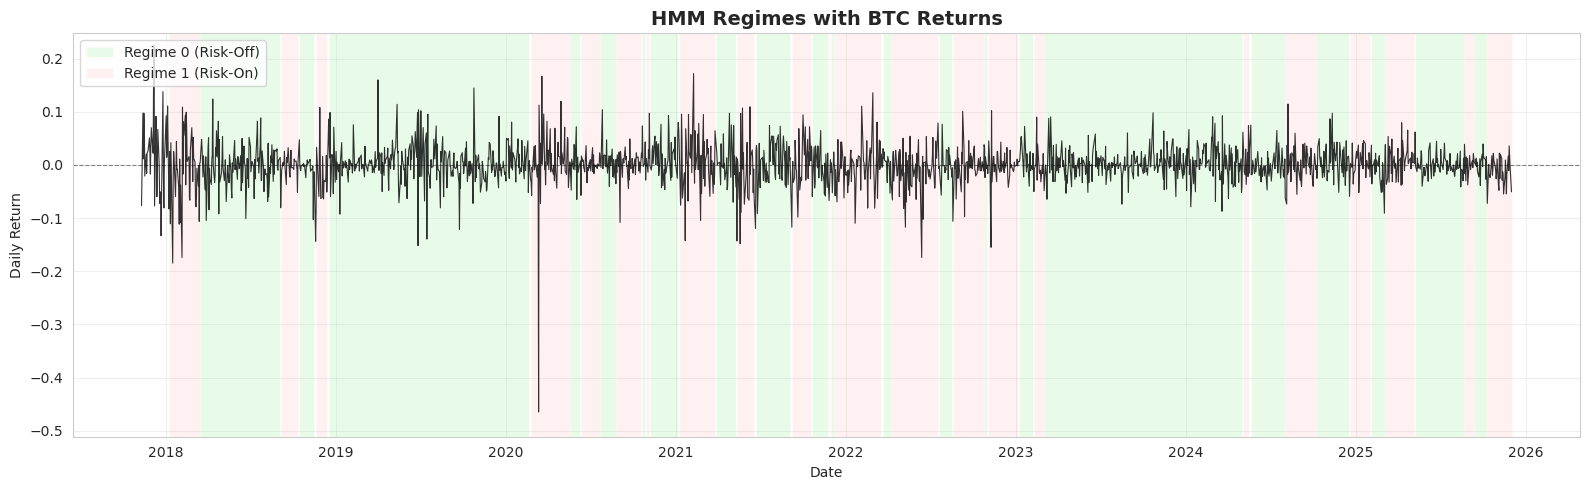

In [47]:
# Plot HMM regime timeline with BTC returns
fig, ax = plt.subplots(figsize=(16, 5))

returns = features['BTC-USD_ret']
y_min, y_max = returns.min() * 1.1, returns.max() * 1.1

# Plot regime backgrounds - only where each regime is active
regime_0_mask = (hmm_regimes == 0)
regime_1_mask = (hmm_regimes == 1)

# Fill background for Regime 0 (only where it's active)
ax.fill_between(hmm_regimes.index, y_min, y_max, 
                where=regime_0_mask, 
                facecolor='#90EE90', alpha=0.2, label='Regime 0 (Risk-Off)')

# Fill background for Regime 1 (only where it's active)
ax.fill_between(hmm_regimes.index, y_min, y_max, 
                where=regime_1_mask, 
                facecolor='#FFB6C1', alpha=0.2, label='Regime 1 (Risk-On)')

# Plot returns on top
ax.plot(returns.index, returns.values, color='black', alpha=0.8, linewidth=0.8, zorder=3)

ax.set_title('HMM Regimes with BTC Returns', fontsize=14, fontweight='bold')
ax.set_xlabel('Date')
ax.set_ylabel('Daily Return')
ax.set_ylim(y_min, y_max)
ax.legend(loc='upper left')
ax.grid(alpha=0.3, zorder=1)
ax.axhline(0, color='gray', linestyle='--', linewidth=0.8, zorder=2)

plt.tight_layout()
plt.show()

| HMM Regime | Interpretation                                                      |
|------------|---------------------------------------------------------------------|
| **Regime 0** | Calmer market phase with lower volatility and smaller price swings  |
| **Regime 1** | More turbulent phase with higher volatility and larger price swings |

The HMM successfully identifies two distinct market regimes with strong temporal persistence. Regime transitions appear infrequent, suggesting the model captures sustained periods of market behavior rather than reacting to short-term noise. The colored bands align with periods of heightened volatility (wider price swings) versus calmer market conditions. This temporal smoothness reflects the HMM's inherent bias toward state persistence through its transition matrix, making it particularly effective at detecting regime shifts that last multiple days or weeks. traduis moi ca, explique le moi et dis moi si je dois le changer ou pas cesr le markdown juste en dessous du graphique de hmm

### GMM Regime Timeline

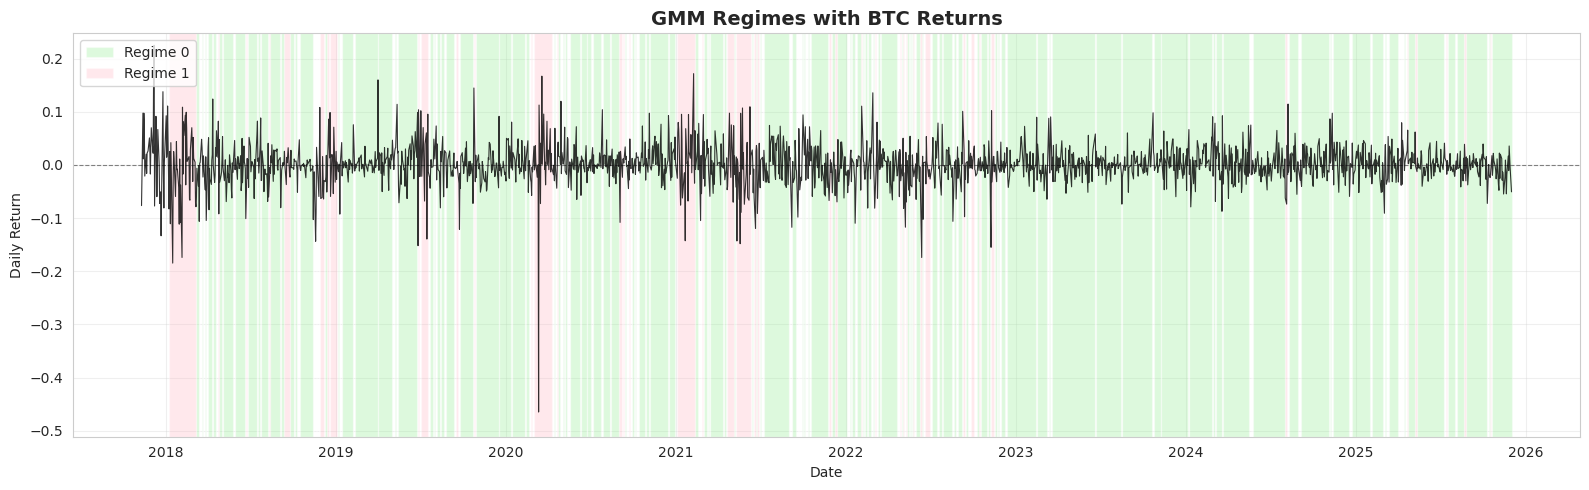

In [48]:
# Plot GMM regime timeline with BTC returns
fig, ax = plt.subplots(figsize=(16, 5))

y_min, y_max = returns.min() * 1.1, returns.max() * 1.1

# Plot regime backgrounds - only where each regime is active
regime_0_mask = (gmm_regimes == 0)
regime_1_mask = (gmm_regimes == 1)

# Fill background for Regime 0 (only where it's active)
ax.fill_between(gmm_regimes.index, y_min, y_max, 
                where=regime_0_mask, 
                facecolor='#90EE90', alpha=0.3, label='Regime 0')

# Fill background for Regime 1 (only where it's active)
ax.fill_between(gmm_regimes.index, y_min, y_max, 
                where=regime_1_mask, 
                facecolor='#FFB6C1', alpha=0.3, label='Regime 1')

# Plot returns on top
ax.plot(returns.index, returns.values, color='black', alpha=0.8, linewidth=0.8, zorder=3)

ax.set_title('GMM Regimes with BTC Returns', fontsize=14, fontweight='bold')
ax.set_xlabel('Date')
ax.set_ylabel('Daily Return')
ax.set_ylim(y_min, y_max)
ax.legend(loc='upper left')
ax.grid(alpha=0.3, zorder=1)
ax.axhline(0, color='gray', linestyle='--', linewidth=0.8, zorder=2)

plt.tight_layout()
plt.show()

| GMM Regime  | Interpretation                                                                 |
|-------------|---------------------------------------------------------------------------------|
| **Regime 0** | Represents the “typical” market behavior. Most observations fall here, showing that daily returns and volatility follow usual statistical patterns. |
| **Regime 1** | Captures atypical observations — short bursts where features deviate from the normal distribution (local volatility spikes, anomalies, or brief structural changes). |

The GMM displays much more frequent regime switching than the HMM, often alternating states even over short time windows. This pattern arises from GMM’s memoryless nature: each day is clustered independently based only on its feature values, with no temporal smoothing. As a result, the model reacts strongly to day-to-day changes in returns and volatility. This sensitivity helps capture subtle distributional differences, but it can also introduce noise by assigning different regimes to consecutive days whose underlying market conditions are essentially similar.

### Autoencoder Regime Timeline

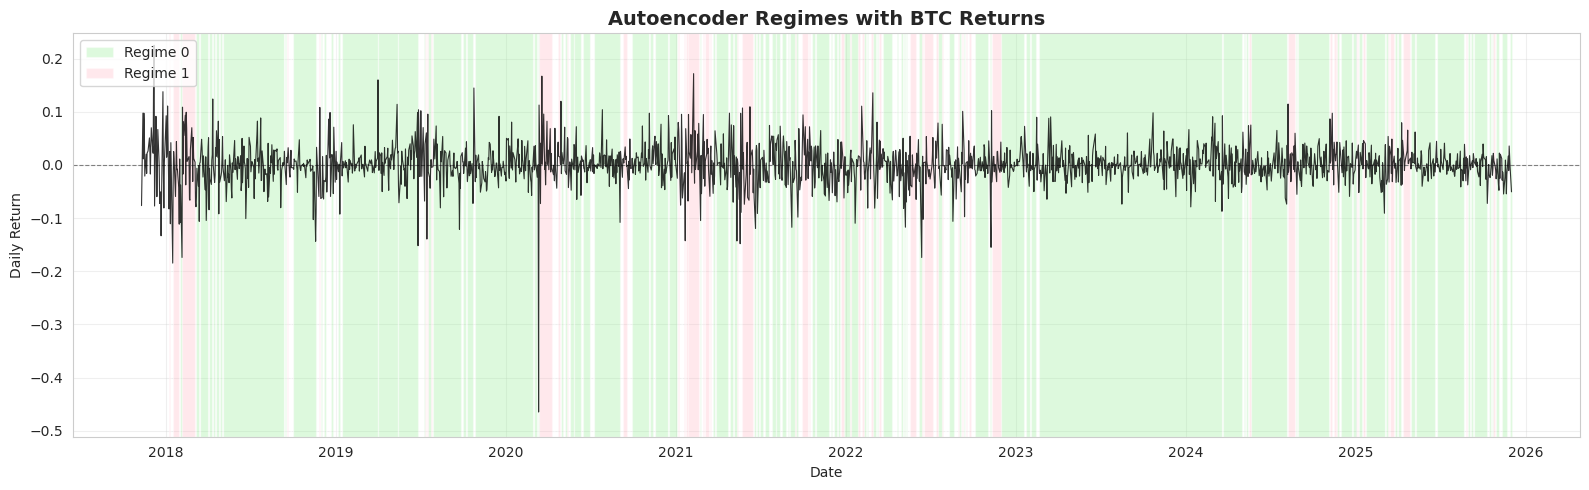

In [49]:
# Plot Autoencoder regime timeline with BTC returns
fig, ax = plt.subplots(figsize=(16, 5))

y_min, y_max = returns.min() * 1.1, returns.max() * 1.1

# Plot regime backgrounds - only where each regime is active
regime_0_mask = (ae_regimes == 0)
regime_1_mask = (ae_regimes == 1)

# Fill background for Regime 0 (only where it's active)
ax.fill_between(ae_regimes.index, y_min, y_max, 
                where=regime_0_mask, 
                facecolor='#90EE90', alpha=0.3, label='Regime 0')

# Fill background for Regime 1 (only where it's active)
ax.fill_between(ae_regimes.index, y_min, y_max, 
                where=regime_1_mask, 
                facecolor='#FFB6C1', alpha=0.3, label='Regime 1')

# Plot returns on top
ax.plot(returns.index, returns.values, color='black', alpha=0.8, linewidth=0.8, zorder=3)

ax.set_title('Autoencoder Regimes with BTC Returns', fontsize=14, fontweight='bold')
ax.set_xlabel('Date')
ax.set_ylabel('Daily Return')
ax.set_ylim(y_min, y_max)
ax.legend(loc='upper left')
ax.grid(alpha=0.3, zorder=1)
ax.axhline(0, color='gray', linestyle='--', linewidth=0.8, zorder=2)

plt.tight_layout()
plt.show()

| AE Regime   | Interpretation                                                                                       |
|-------------|-------------------------------------------------------------------------------------------------------|
| **Regime 0** | Market behavior close to the learned nonlinear patterns — structurally “normal” days, lower deviation |
| **Regime 1** | Structural anomalies or deviations from typical patterns — higher reconstruction error, sudden shifts |

The Autoencoder’s regime assignments sit between the HMM’s temporal smoothness and the GMM’s high sensitivity. 
By learning a compressed nonlinear representation of the feature space, the neural network can capture complex interactions between volatility, returns, and cross-asset correlations that linear methods may miss. 
Regime transitions occur more frequently than in the HMM, yet remain more stable than those produced by the GMM, suggesting that the latent space captures meaningful structural patterns. 
This makes the Autoencoder particularly effective at identifying regime boundaries where several features shift simultaneously in nonlinear ways.

### Reconstruction Error (Autoencoder)

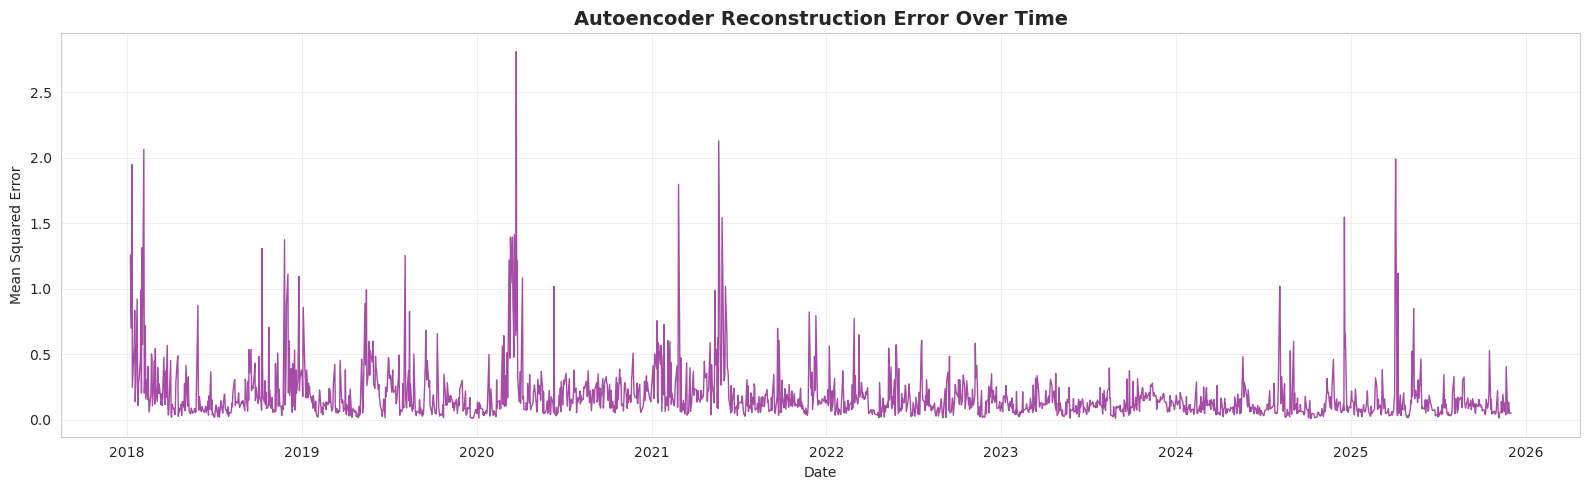

In [50]:
# Plot reconstruction error over time
import torch

X_df = features[list(ae_feats)].dropna()
X_scaled = ae_scaler.transform(X_df.values)
X_tensor = torch.FloatTensor(X_scaled)

ae_model.eval()
with torch.no_grad():
    x_recon, _ = ae_model(X_tensor)
    reconstruction_error = ((X_tensor - x_recon) ** 2).mean(dim=1).numpy()

fig, ax = plt.subplots(figsize=(16, 5))
ax.plot(X_df.index, reconstruction_error, color='purple', alpha=0.7, linewidth=1)
ax.set_title('Autoencoder Reconstruction Error Over Time', fontsize=14, fontweight='bold')
ax.set_xlabel('Date')
ax.set_ylabel('Mean Squared Error')
ax.grid(alpha=0.3)
plt.tight_layout()
plt.show()

| Observation Type              | Meaning                                                                                           |
|-------------------------------|---------------------------------------------------------------------------------------------------|
| **Low Reconstruction Error**  | Market behavior matches learned patterns; the autoencoder reconstructs features well.             |
| **Moderate Error**            | Slight deviations from normal structure; mild changes in volatility or correlations.              |
| **High Reconstruction Error** | Structural anomaly: abrupt shifts in market behavior (volatility spikes, correlation breakdowns, or sudden regime boundaries). |

## Discussion

### 1. Key Findings & Model Insights

| Question | Answer |
|---------|--------|
| **What did the three models reveal about crypto regimes?** | All models detect alternating phases of calm vs turbulent BTC market behavior, but with very different regime boundaries. |
| **Why do the models disagree?** | Because each relies on a different assumption: HMM uses temporal persistence, GMM clusters distributions, AE learns nonlinear structure. |
| **What does each model capture best?** | **HMM:** persistent long-term regimes. **GMM:** statistical clusters & distribution shifts. **AE:** nonlinear anomalies & subtle feature changes. |

---

### 2. Economic Interpretation

| Aspect | Interpretation |
|--------|----------------|
| **Risk-Off regime** | Characterized by lower volatility, tighter return dispersion, and smoother behavior. |
| **Risk-On regime** | Episodes of higher volatility, larger price swings, and cross-asset correlation breakdowns. |
| **Are regimes economically meaningful?** | Yes — regime labels correspond to well-known market stress periods (COVID crash, 2022–23 bear market, etc.). |

---

### 3. Practical Implications

| Use Case | Best Model | Why? |
|----------|------------|------|
| **Short-term trading** | **GMM** | Fast reaction to distribution changes → sensitive to local volatility spikes. |
| **Risk management** | **HMM** | Stable regime sequences → fewer false switches → better macro risk timing. |
| **Anomaly detection** | **Autoencoder** | Reconstruction error highlights nonlinear market distortions. |

---

### 4. Connection to Risk-On / Risk-Off Theory

| Question | Answer |
|----------|--------|
| **Do results support the Risk-On / Risk-Off hypothesis?** | **Partially.** All models consistently identify high-volatility vs low-volatility phases, matching Risk-On/Off theory, but regime boundaries vary depending on model assumptions. |

## Conclusion

Our results show that Risk-On/Risk-Off regimes can indeed be detected in crypto markets, but the detected boundaries depend heavily on the model's underlying assumptions. HMM provides the most stable and interpretable macro-regime structure, GMM reacts most quickly to volatility shifts, and the Autoencoder captures nonlinear distortions missed by classical methods. 

Overall, HMM is best suited for risk management, GMM for short-term monitoring, and the Autoencoder for anomaly detection. Practitioners should select the model based on their specific objective rather than expecting a single “true” regime sequence.

Future work may include richer feature sets, multi-state models, and evaluating how regime detection improves portfolio decisions.